In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
from scipy import stats
import math

In [148]:
df = pd.read_csv('sushan_daily_updated.csv')
mask = df['symbol'].str.contains('BA')
df['20days_AM'] = None
df.loc[mask,'20days_AM'] = df[mask]['total_vol'].rolling(20).mean()
df['log_20days_AM'] = None
df.loc[mask, 'log_20days_AM'] = (np.log(df[mask]['total_vol'])).shift().rolling(20).mean()
df['y_true'] = None
df.loc[mask,'y_true'] = np.log(df[mask]['total_vol'])- df[mask]['log_20days_AM']
data = df[mask].iloc[20:]
data
#data.to_csv('testing.csv')


,Unnamed: 0,DATE,SYM_ROOT,total_vol,symbol,CSize,CPrc,OPrc,total_vol_m,total_vol_b,total_vol_a,Ovn_Gap,20days_AM,log_20days_AM,y_true
30,30,2019/01/30,BA,11755060,BA,195467,387.72,387.40,11950792,548589.0,208628.0,22.49,3616953.45,14.942168,1.337626
31,31,2019/01/31,BA,5526672,BA,1093448,385.62,386.99,6618882,24129.0,235733.0,-0.73,3762493.0,15.010438,0.514658
32,32,2019/02/01,BA,4053990,BA,872249,387.43,387.00,4926113,42482.0,657392.0,1.38,3718674.45,15.047837,0.167375
33,33,2019/02/04,BA,3640190,BA,326206,397.00,388.50,3967066,7895.0,283361.0,1.07,3716940.8,15.038052,0.069495
34,34,2019/02/05,BA,6068814,BA,926707,410.18,400.75,6995875,96682.0,138570.0,3.75,3867152.65,15.037578,0.581096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,5804,2021/12/27,BA,7271163,BA,253331,203.17,201.96,7523713,95126.0,208367.0,-2.26,9525519.4,16.070078,-0.270652
5805,5805,2021/12/28,BA,8333741,BA,240289,206.13,202.23,8574671,62362.0,256928.0,-0.94,9365523.3,16.029645,-0.093822
5806,5806,2021/12/29,BA,5645408,BA,240570,203.66,205.05,5886519,47561.0,188310.0,-1.08,9099353.6,16.013398,-0.467045
5807,5807,2021/12/30,BA,6693702,BA,159322,202.71,203.00,6854595,49387.0,110237.0,-0.66,8810430.3,15.980187,-0.263509


In [149]:
#split data into testing data 70%,  and training data 30%
n = int(len(data) * 0.7)
train = data[:n]
valid = data[n:]

In [200]:
# find y_hat given y_true 
def estimate_y(y_true, phi, theta):
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1,n):
      #  eps[t] = y_true[t] - phi*y_true[t-1]
        y_hat[t] = phi*y_true[t-1] + theta * eps[t-1]
        eps[t] = y_true[t] - y_hat[t]
    return y_hat

In [201]:
y_true_np = np.array(train['y_true'].values)
y_true_np[:10]


array([1.3376258951992632, 0.5146582582581161, 0.1673747693890082,
       0.06949459761032273, 0.5810959171011518, 0.28446625951631255,
       0.2581343715086817, 0.06692284387732705, -0.28606924325649175,
       -0.27083404048072346], dtype=object)

In [202]:
train.loc[:,'y_hat'] = estimate_y(y_true_np, 0.7, -0.3)
train

/Users/zss/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Unnamed: 0,DATE,SYM_ROOT,total_vol,symbol,CSize,CPrc,OPrc,total_vol_m,total_vol_b,total_vol_a,Ovn_Gap,20days_AM,log_20days_AM,y_true,y_hat
30,30,2019/01/30,BA,11755060,BA,195467,387.72,387.40,11950792,548589.0,208628.0,22.49,3616953.45,14.942168,1.337626,0.000000
31,31,2019/01/31,BA,5526672,BA,1093448,385.62,386.99,6618882,24129.0,235733.0,-0.73,3762493.0,15.010438,0.514658,0.936338
32,32,2019/02/01,BA,4053990,BA,872249,387.43,387.00,4926113,42482.0,657392.0,1.38,3718674.45,15.047837,0.167375,0.486765
33,33,2019/02/04,BA,3640190,BA,326206,397.00,388.50,3967066,7895.0,283361.0,1.07,3716940.8,15.038052,0.069495,0.212979
34,34,2019/02/05,BA,6068814,BA,926707,410.18,400.75,6995875,96682.0,138570.0,3.75,3867152.65,15.037578,0.581096,0.091692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5582,5582,2021/02/09,BA,13104346,BA,138197,215.12,210.51,13242796,136337.0,236709.0,-1.44,10698157.0,16.171223,0.217232,-0.071888
5583,5583,2021/02/10,BA,11420984,BA,216009,211.92,215.98,11635508,92930.0,132439.0,0.86,10681142.8,16.163654,0.087309,0.065326
5584,5584,2021/02/11,BA,6840142,BA,121215,210.66,211.92,6961246,87850.0,104267.0,0.00,10612709.7,16.162186,-0.423867,0.054522
5585,5585,2021/02/12,BA,5295345,BA,233288,210.98,210.22,5528025,45984.0,436966.0,-0.44,10318918.2,16.153066,-0.670727,-0.153190


In [203]:
from scipy.optimize import minimize 

def my_objective(param, y_true):
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y(y_true, phi, theta)
    y_diff = y_hat - y_true
    ALE = np.sum((1.5 + 0.5*np.sign(y_diff)) * np.abs(y_diff))
    return ALE 

res = minimize(my_objective, np.array([0.5,0.5]), args=y_true_np)
phi, theta = res.x

phi, theta

(0.7828633365785371, -0.3057386076601923)

In [206]:
#use the phi and theta optimized from the train to get the estimate volumes in test 
y_true_test= np.array(valid['y_true'].values)
valid.loc[:,'y_hat'] = estimate_y(y_true_test, 0.7828633365785371, -0.3057386076601923)
valid['log_total_vol_hat'] = valid['y_hat'] + valid['log_20days_AM']

/Users/zss/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/var/folders/f2/41ckpyln3370bz1wf7vdknb80000gn/T/ipykernel_94694/1356965248.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['log_total_vol_hat'] = valid['y_hat'] + valid['log_20days_AM']


In [209]:
valid


,Unnamed: 0,DATE,SYM_ROOT,total_vol,symbol,CSize,CPrc,OPrc,total_vol_m,total_vol_b,total_vol_a,Ovn_Gap,20days_AM,log_20days_AM,y_true,y_hat,log_total_vol_hat,log_total_vol
5587,5587.0,2021-02-17,BA,8696597.0,BA,335789.0,215.52,215.52,9032051.0,83932.0,182124.0,-1.66,10145772.3,16.110859,-0.132416,0.000000,16.110859,15.978442
5588,5588.0,2021-02-18,BA,8644665.0,BA,177845.0,208.48,213.33,8822677.0,112603.0,186477.0,-2.19,10122945.2,16.098121,-0.125668,-0.103664,15.994457,15.972453
5589,5589.0,2021-02-19,BA,11792292.0,BA,270664.0,217.47,209.97,12065655.0,97385.0,255445.0,1.49,10209658.2,16.095548,0.187409,-0.091654,16.003895,16.282957
5590,5590.0,2021-02-22,BA,19920737.0,BA,355827.0,212.88,211.55,20350681.0,910615.0,229983.0,-5.92,10858335.2,16.103502,0.70377,0.061395,16.164897,16.807272
5591,5591.0,2021-02-23,BA,15750677.0,BA,449208.0,212.12,214.71,16200125.0,313529.0,83230.0,1.83,10990811.6,16.156173,0.416221,0.354557,16.51073,16.572394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5805,5805.0,2021-12-28,BA,8333741.0,BA,240289.0,206.13,202.23,8574671.0,62362.0,256928.0,-0.94,9365523.3,16.029645,-0.093822,-0.186047,15.843599,15.935823
5806,5806.0,2021-12-29,BA,5645408.0,BA,240570.0,203.66,205.05,5886519.0,47561.0,188310.0,-1.08,9099353.6,16.013398,-0.467045,-0.101647,15.911751,15.546353
5807,5807.0,2021-12-30,BA,6693702.0,BA,159322.0,202.71,203.00,6854595.0,49387.0,110237.0,-0.66,8810430.3,15.980187,-0.263509,-0.253916,15.726271,15.716678
5808,5808.0,2021-12-31,BA,7565632.0,BA,356882.0,201.32,202.20,7922868.0,45020.0,85616.0,-0.51,8274982.05,15.94907,-0.109944,-0.203359,15.745712,15.839126


In [156]:
valid['DATE'] = pd.to_datetime(valid['DATE'])

/var/folders/f2/41ckpyln3370bz1wf7vdknb80000gn/T/ipykernel_94694/1164688626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['DATE'] = pd.to_datetime(valid['DATE'])


In [208]:
valid['log_total_vol'] = None
valid.loc[:,'log_total_vol'] = np.log(valid['total_vol'])

/var/folders/f2/41ckpyln3370bz1wf7vdknb80000gn/T/ipykernel_94694/3161603589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['log_total_vol'] = None
/Users/zss/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


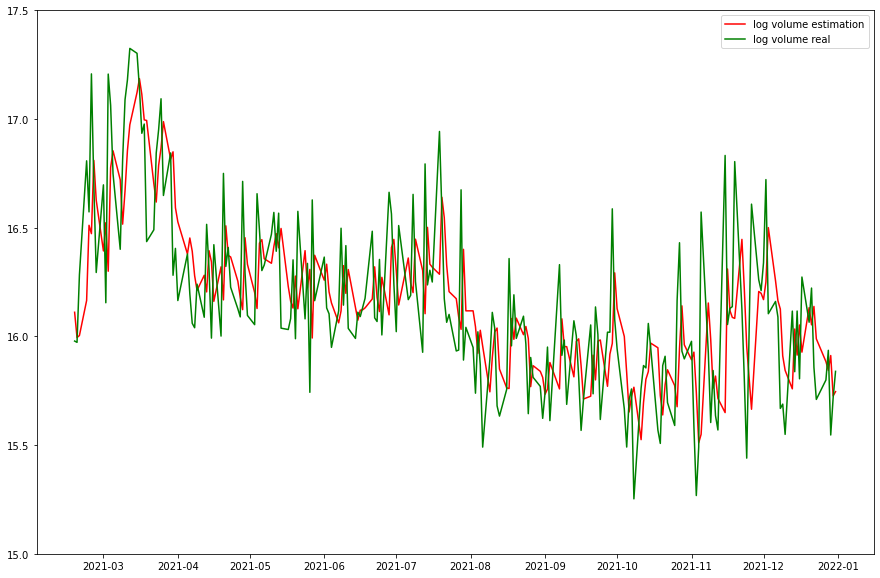

In [214]:
plt.rcParams["figure.figsize"] = [15, 10]
x = valid['DATE']
y1 = valid['log_total_vol_hat']
y2 = valid['log_total_vol']
plt.plot(x, y1, color = 'r', label = 'log volume estimation')
plt.ylim(ymin=15,ymax=17.5)
plt.plot(x, y2, color = 'g', label = 'log volume real')
plt.legend()
plt.show()